### Attempting to compute Fisher matrix

#### First: calculate derivative
### $\frac{\partial\chi}{\partial\Omega_m} \simeq \frac{\chi(\Omega_m^+)-\chi(\Omega_m^-)}{2\Delta\Omega_m}$

In [7]:

def get_filenames(rmin,rmax,rbin,njk,ns,cosm,space):
    filename = f'vpfdata_{rmin}-{rmax}-{rbin}-{njk}-{ns}-{cosm}-{space}-*.dat'
    return filename
def compute_mean_cov(summaries):
    mean = np.mean(summaries, axis=0)
    covariance = np.cov(summaries.T)
    inverse_covariance = np.linalg.solve(
        covariance, np.eye(len(covariance), len(covariance))
    )
    corrm = np.corrcoef(summaries.T)
    return mean, covariance, inverse_covariance, corrm

import glob
import numpy as np
from astropy.io import ascii

# Parameters
# cosm = 'Om_m'
ns = int(10000)
rbin = int(13)
rmin, rmax = 3., int(25)
njk = int(10)
space = 'zspace'
#filedir = '/home/federico/mnts/clemente/Proyectos/VPF_Quijote/data/output/'
filedir = '../data/output/'

for cosm in ['Om_m','Om_p','fiducial']:

    filenames = get_filenames(rmin,rmax,rbin,njk,ns,cosm,space)

    filelist = glob.glob(filedir+filenames)
    nsim = len(filelist)
    print(cosm, nsim)

    chis = []
    nxis = []
    chi_stds = []

    #if cosm != 'fiducial': filelist=filelist[:100]
    # Read all files
    for file in filelist:
        #print(file)
        data = ascii.read(file)
        chis.append( data['chi'] )
        nxis.append( data['N_mean']*data['xi'] )
        chi_stds.append( data['chi_std'] )


    if cosm=='Om_m':
        mean_Om_m, covariance_Om_m, inverse_covariance_Om_m, corrm_Om_m = compute_mean_cov(np.array(chis))
    if cosm=='Om_p':
        mean_Om_p, covariance_Om_p, inverse_covariance_Om_p, corrm_Om_p = compute_mean_cov(np.array(chis))
    if cosm=='fiducial':
        mean_fid, covariance_fid, inverse_covariance_fid, corrm_fid = compute_mean_cov(np.array(chis))

mu_Om = 0.3175

dChi_dOm = (mean_Om_p-mean_Om_m)/(2*0.01)
print(dChi_dOm)

Om_m 499
Om_p 499
fiducial 2994
[0.1048947  0.11547409 0.12328855 0.14085106 0.15246374 0.16425752
 0.17693983 0.18933592 0.19949518 0.21377157 0.2240339  0.23641461
 0.24261951]


#### Fisher forecast for $\Omega_m$
#### $F_{\Omega_m}=\frac{\partial\chi}{d\Omega_m}C^{-1}\frac{\partial\chi^T}{d\Omega_m}$
#### $\sigma_{\Omega_m}^2=(F^{-1})_{\Omega_m}$

In [8]:
covfactor = (2994-1)/(2994-13+6-1)
f_Om = dChi_dOm @ np.linalg.inv(covfactor*covariance_fid) @ dChi_dOm.T
#sigma_Om = np.sqrt(1/f_Om)

print(f_Om)

28652.03867846509


In [9]:
# def gaussian(x,mu,sigma,norm=True):
#     g = np.exp(-(x - mu)**2 / (2 * sigma**2))
#     if norm==True:
#         g /= g.max()
#     return g

# import matplotlib.pyplot as plt
# import numpy as np

# lw = 3
# mu_Om = 0.3175
# x = np.linspace(mu_Om - 6*sigma_Om, mu_Om + 6*sigma_Om, 100)
# plt.plot(x, gaussian(x, mu_Om, 0.04221), label='2PCF', lw=lw)
# plt.plot(x, gaussian(x, mu_Om, sigma_Om), label='VPF', lw=lw)
# plt.plot(x, gaussian(x, mu_Om, 0.01128), label='DS', lw=lw)
# plt.xlabel(r'$\Omega_m$')
# plt.legend()
# plt.show()

### Same with $h$

In [10]:

def get_filenames(rmin,rmax,rbin,njk,ns,cosm,space):
    filename = f'vpfdata_{rmin}-{rmax}-{rbin}-{njk}-{ns}-{cosm}-{space}-*.dat'
    return filename
def compute_mean_cov(summaries):
    mean = np.mean(summaries, axis=0)
    covariance = np.cov(summaries.T)
    inverse_covariance = np.linalg.solve(
        covariance, np.eye(len(covariance), len(covariance))
    )
    corrm = np.corrcoef(summaries.T)
    return mean, covariance, inverse_covariance, corrm

import glob
import numpy as np
from astropy.io import ascii

# Parameters
ns = int(10000)
rbin = int(13)
rmin, rmax = 3., int(25)
njk = int(10)
space = 'zspace'
#filedir = '/home/federico/mnts/clemente/Proyectos/VPF_Quijote/data/output/'
filedir = '../data/output/'

for cosm in ['h_m','h_p','fiducial']:

    filenames = get_filenames(rmin,rmax,rbin,njk,ns,cosm,space)

    filelist = glob.glob(filedir+filenames)
    nsim = len(filelist)
    print(cosm, nsim)

    chis = []
    nxis = []
    chi_stds = []

    #if cosm != 'fiducial': filelist=filelist[:100]
    # Read all files
    for file in filelist:
        #print(file)
        data = ascii.read(file)
        chis.append( data['chi'] )
        nxis.append( data['N_mean']*data['xi'] )
        chi_stds.append( data['chi_std'] )


    if cosm=='h_m':
        mean_h_m, covariance_h_m, inverse_covariance_h_m, corrm_h_m = compute_mean_cov(np.array(chis))
    if cosm=='h_p':
        mean_h_p, covariance_h_p, inverse_covariance_h_p, corrm_h_p = compute_mean_cov(np.array(chis))
    if cosm=='fiducial':
        mean_fid, covariance_fid, inverse_covariance_fid, corrm_fid = compute_mean_cov(np.array(chis))

h_fid = 0.6711
h_m = 0.6511
h_p = 0.6911
delta_h = h_p-h_fid
#print(delta_h)
dChi_dh = (mean_h_p-mean_h_m)/(2*delta_h)
#print(dChi_dh)

##########################################################################
# Fisher factor
covfactor = (2994-1)/(2994-13+6-1)
f_h = dChi_dh @ np.linalg.inv(covfactor*covariance_fid) @ dChi_dh.T
#sigma_h = np.sqrt(1/f_h)

print('sigma_h:',f_h)

##########################################################################
# Plot
# def gaussian(x,mu,sigma,norm=True):
#     g = np.exp(-(x - mu)**2 / (2 * sigma**2))
#     if norm==True:
#         g /= g.max()
#     return g

# import matplotlib.pyplot as plt
# import numpy as np

# lw = 3
# x = np.linspace(h_fid - 6*sigma_h, h_fid + 6*sigma_h, 100)
# plt.plot(x, gaussian(x, h_fid, 0.20976), label='2PCF', lw=lw)
# plt.plot(x, gaussian(x, h_fid, sigma_h), label='VPF', lw=lw)
# plt.plot(x, gaussian(x, h_fid, 0.0656), label='DS', lw=lw)
# plt.xlabel(r'$h$')
# plt.legend()
# plt.show()

h_m 499
h_p 499
fiducial 2994
sigma_h: 3227.5118341857665


### Same for $n_s$

In [11]:

def get_filenames(rmin,rmax,rbin,njk,ns,cosm,space):
    filename = f'vpfdata_{rmin}-{rmax}-{rbin}-{njk}-{ns}-{cosm}-{space}-*.dat'
    return filename
def compute_mean_cov(summaries):
    mean = np.mean(summaries, axis=0)
    covariance = np.cov(summaries.T)
    inverse_covariance = np.linalg.solve(
        covariance, np.eye(len(covariance), len(covariance))
    )
    corrm = np.corrcoef(summaries.T)
    return mean, covariance, inverse_covariance, corrm

import glob
import numpy as np
from astropy.io import ascii

# Parameters
ns = int(10000)
rbin = int(13)
rmin, rmax = 3., int(25)
njk = int(10)
space = 'zspace'
#filedir = '/home/federico/mnts/clemente/Proyectos/VPF_Quijote/data/output/'
filedir = '../data/output/'

for cosm in ['ns_m','ns_p','fiducial']:

    filenames = get_filenames(rmin,rmax,rbin,njk,ns,cosm,space)

    filelist = glob.glob(filedir+filenames)
    nsim = len(filelist)
    print(cosm, nsim)

    chis = []
    nxis = []
    chi_stds = []

    #if cosm != 'fiducial': filelist=filelist[:100]
    # Read all files
    for file in filelist:
        #print(file)
        data = ascii.read(file)
        chis.append( data['chi'] )
        nxis.append( data['N_mean']*data['xi'] )
        chi_stds.append( data['chi_std'] )


    if cosm=='ns_m':
        mean_ns_m, covariance_ns_m, inverse_covariance_ns_m, corrm_ns_m = compute_mean_cov(np.array(chis))
    if cosm=='ns_p':
        mean_ns_p, covariance_ns_p, inverse_covariance_ns_p, corrm_ns_p = compute_mean_cov(np.array(chis))
    if cosm=='fiducial':
        mean_fid, covariance_fid, inverse_covariance_fid, corrm_fid = compute_mean_cov(np.array(chis))

ns_fid = 0.9624
ns_m = 0.9424
ns_p = 0.9824
delta_ns = ns_p-ns_fid
print(delta_ns)
dChi_dns = (mean_ns_p-mean_ns_m)/(2*delta_ns)
print(dChi_dh)

##########################################################################
# Fisher factor
covfactor = (2994-1)/(2994-13+6-1)
f_ns = dChi_dns @ np.linalg.inv(covfactor*covariance_fid) @ dChi_dns.T
#sigma_ns = np.sqrt(1/f_ns)

print(f_ns)

##########################################################################
# Plot
# def gaussian(x,mu,sigma,norm=True):
#     g = np.exp(-(x - mu)**2 / (2 * sigma**2))
#     if norm==True:
#         g /= g.max()
#     return g

# import matplotlib.pyplot as plt
# import numpy as np

# lw = 3
# x = np.linspace(ns_fid - 6*sigma_ns, ns_fid + 6*sigma_ns, 100)
# plt.plot(x, gaussian(x, ns_fid, 0.24549), label='2PCF', lw=lw)
# plt.plot(x, gaussian(x, ns_fid, sigma_ns), label='VPF', lw=lw)
# plt.plot(x, gaussian(x, ns_fid, 0.04231), label='DS', lw=lw)
# plt.xlabel(r'$n_s$')
# plt.legend()
# plt.show()

ns_m 500
ns_p 499
fiducial 2994
0.020000000000000018
[0.02062418 0.02901314 0.03321941 0.03881942 0.04675762 0.05182013
 0.059007   0.06482634 0.07009368 0.07479848 0.07900195 0.08453194
 0.08801257]
4561.392465345359


### Attempting to make triangle plot

Removed no burn in
Removed no burn in
Removed no burn in


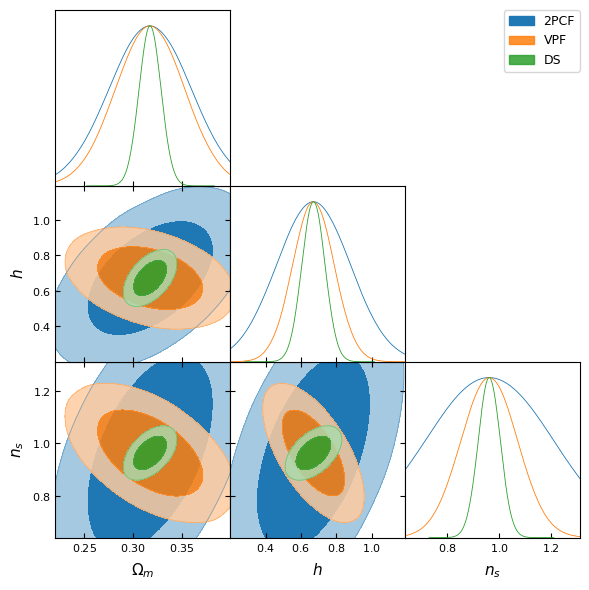

In [13]:
from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt


# Computing fisher element Om,h
f_Omh = dChi_dOm @ np.linalg.inv(covfactor*covariance_fid) @ dChi_dh.T
# Computing fisher element Om,ns
f_Omns = dChi_dOm @ np.linalg.inv(covfactor*covariance_fid) @ dChi_dns.T
# Computing fisher element h,ns
f_hns = dChi_dh @ np.linalg.inv(covfactor*covariance_fid) @ dChi_dns.T


rho = 0.5 # correlation coefficient
samples = ['Om','h','ns']
labels = [r'\Omega_m',r'h',r'n_s']
mean_theta = [mu_Om,h_fid,ns_fid]
random_state = np.random.default_rng(10)

# add fisher errors as MC samples
#DS
sigma_Om_ds = 0.01128
sigma_h_ds = 0.06560
sigma_ns_ds = 0.04231
cov_theta = np.array([[sigma_Om_ds**2, rho*sigma_Om_ds*sigma_h_ds, rho*sigma_Om_ds*sigma_ns_ds],
                      [rho*sigma_Om_ds*sigma_h_ds, sigma_h_ds**2, rho*sigma_h_ds*sigma_ns_ds],
                      [rho*sigma_Om_ds*sigma_ns_ds, rho*sigma_h_ds*sigma_ns_ds, sigma_ns_ds**2]])
samp = random_state.multivariate_normal(mean_theta, cov_theta, size=1000000)
mcs_ds = MCSamples(samples=samp, names=samples, labels=labels)

#VPF
fisher_matrix = np.array([[f_Om, f_Omh, f_Omns],
                           [f_Omh, f_h, f_hns],
                           [f_Omns, f_hns, f_ns]])
#fisher_matrix = np.array([[f_Om, f_Omh],
#                          [f_Omh, f_h]])
cov_theta = np.linalg.inv(fisher_matrix) # WHY DOES THIS NOT WORK??
#cov_theta = np.array([[sigma_Om**2, 1/f_Omh, 1/f_Omns],
#                      [1/f_Omh, sigma_h**2, 1/f_hns],
#                      [1/f_Omns, 1/f_hns, sigma_ns**2]])
samp = random_state.multivariate_normal(mean_theta, cov_theta, size=1000000)
mcs_vpf = MCSamples(samples=samp, names=samples, labels=labels)


#2PCF
sigma_Om_2pcf = 0.04221
sigma_h_2pcf = 0.20976
sigma_ns_2pcf = 0.24549
cov_theta = np.array([[sigma_Om_2pcf**2, rho*sigma_Om_2pcf*sigma_h_2pcf, rho*sigma_Om_2pcf*sigma_ns_2pcf],
                      [rho*sigma_Om_2pcf*sigma_h_2pcf, sigma_h_2pcf**2, rho*sigma_h_2pcf*sigma_ns_2pcf],
                      [rho*sigma_ns_2pcf*sigma_Om_2pcf, rho*sigma_ns_2pcf*sigma_h_2pcf, sigma_ns_2pcf**2]])
samp = random_state.multivariate_normal(mean_theta, cov_theta, size=1000000)
mcs_2pcf = MCSamples(samples=samp, names=samples, labels=labels)
param_limits = {
    'Om':(0.22, 0.40),
#    'Ob2':(0.01, 0.087),
    'h':(0.20, 1.19),
#    's8':(0.65, 1.05),
    'ns':(0.64, 1.31),
#    'Mnu':(-0.65, 0.65)
}

colors =  plt.rcParams['axes.prop_cycle'].by_key()['color']

# Create a GetDist plotter
g = plots.get_subplot_plotter()

method_labels = ['2PCF','VPF','DS']
# Plot the triangle plot
g.triangle_plot([mcs_2pcf,mcs_vpf,mcs_ds], filled=True, legend_labels=method_labels,
                param_limits=param_limits, contour_colors=colors)

# Show the plot
plt.show()  

#### This plot is still not a fair comparison given that the Fisher matrix for the VPF is of smaller dimensions 

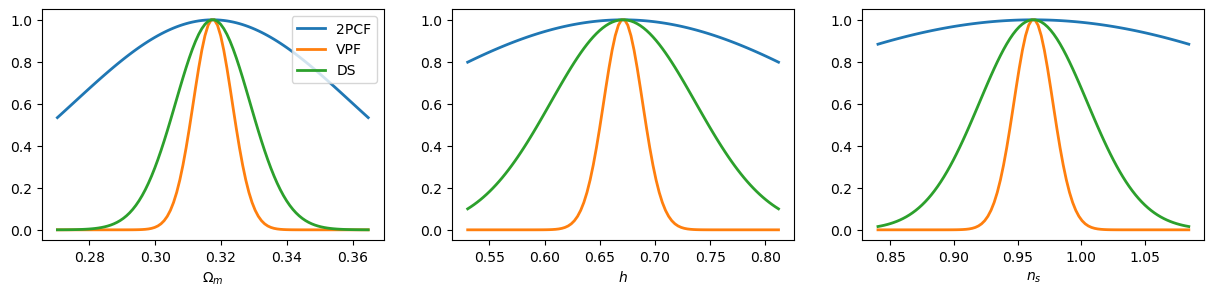

In [ ]:
# def gaussian(x,mu,sigma,norm=True):
#     g = np.exp(-(x - mu)**2 / (2 * sigma**2))
#     if norm==True:
#         g /= g.max()
#     return g

# import matplotlib.pyplot as plt
# import numpy as np

# fig, ax = plt.subplots(1, 3, figsize=(15, 3)) 

# lw = 2
# mu_Om = 0.3175
# x = np.linspace(mu_Om - 8*sigma_Om, mu_Om + 8*sigma_Om, 100)
# ax[0].plot(x, gaussian(x, mu_Om, 0.04221), label='2PCF', lw=lw)
# ax[0].plot(x, gaussian(x, mu_Om, sigma_Om), label='VPF', lw=lw)
# ax[0].plot(x, gaussian(x, mu_Om, 0.01128), label='DS', lw=lw)
# ax[0].set_xlabel(r'$\Omega_m$')

# x = np.linspace(h_fid - 8*sigma_h, h_fid + 8*sigma_h, 100)
# ax[1].plot(x, gaussian(x, h_fid, 0.20976), label='2PCF', lw=lw)
# ax[1].plot(x, gaussian(x, h_fid, sigma_h), label='VPF', lw=lw)
# ax[1].plot(x, gaussian(x, h_fid, 0.0656), label='DS', lw=lw)
# ax[1].set_xlabel(r'$h$')

# x = np.linspace(ns_fid - 8*sigma_ns, ns_fid + 8*sigma_ns, 100)
# ax[2].plot(x, gaussian(x, ns_fid, 0.24549), label='2PCF', lw=lw)
# ax[2].plot(x, gaussian(x, ns_fid, sigma_ns), label='VPF', lw=lw)
# ax[2].plot(x, gaussian(x, ns_fid, 0.04231), label='DS', lw=lw)
# ax[2].set_xlabel(r'$n_s$')

# ax[0].legend(loc=1)
# plt.show()
